In [5]:
from dataset import PerformanceChunks
import torch
import os
import pandas as pd

import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np

from model import Model

In [6]:
class Config:
    def __init__(self, iterable=(), **kwargs):
        self.__dict__.update(iterable, **kwargs)

In [5]:
config = Config({
    "meta_csv": "/home/pasinducw/Downloads/Research-Datasets/covers80/covers80_annotations_single_1.csv",
    "dataset_dir": "/home/pasinducw/Downloads/Research-Datasets/covers80/covers80_features",
    "feature_type": "cqt",
    "time_axis": 1,
    "hop_length": 42,
    "frames_per_sample": 64,
    "dataset_cache_limit": 80,
    "workers": 1,
    "device": "cpu",
    "input_size": 84,
    "hidden_size": 128,
    "batch_size": 1024,
    "model_layers": 2,
})

FREQUENCY IS  0.01179245283018868
Input  torch.Size([100, 64, 84])
Embeddings  torch.Size([100, 128])
Decoder Input 0 torch.Size([100, 1, 84])
Decoder state torch.Size([2, 100, 128]) torch.Size([2, 100, 128])
Decoder outputs  torch.Size([100, 64, 84])
With random decoder inputs
torch.Size([100, 64, 84])


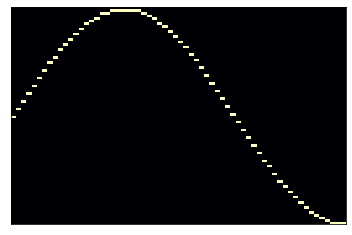

In [6]:
dataset = PerformanceChunks(
    dataset_meta_csv_path=config.meta_csv,
    base_dir=config.dataset_dir,
    feature_type=config.feature_type,
    time_axis=config.time_axis,
    hop_length=config.hop_length,
    frames_per_sample=config.frames_per_sample,
    cache_limit=config.dataset_cache_limit
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=config.batch_size, num_workers=config.workers, shuffle=False)

device = torch.device(config.device)
model = Model(input_size=config.input_size, layers=config.model_layers, share_weights=False,
              embedding_size=config.hidden_size).to(device)

model.train()

for i, (sequence) in enumerate(dataloader):
    sequence = sequence.to(device)
    (embeddings, pred) = model(sequence)
    print(pred.shape)

source = sequence[0] # pred[0]
data=source.detach().numpy().transpose()
librosa.display.specshow(data)

In [9]:
# LogSoftmax dimension test
d = torch.tensor([[1000.,0.,0.], [0.,1.,0.], [0.,0.,1.]])
m = torch.nn.LogSoftmax(dim=1)
m(d)

tensor([[ 0.0000e+00, -1.0000e+03, -1.0000e+03],
        [-1.5514e+00, -5.5144e-01, -1.5514e+00],
        [-1.5514e+00, -1.5514e+00, -5.5144e-01]])

In [ ]:
# Sine wave generation
cqt_coefficients, samples = 84, 4200
freq = 5/4200

steps = np.linspace(0, samples, samples, endpoint=False)
wave = np.sin(2 * np.pi * freq * steps)

wave = ((wave + 1.0) * ((cqt_coefficients-1)/2))
wave = np.floor(wave).astype(int)
plot = np.zeros((cqt_coefficients, samples))

for (index, value) in enumerate(wave):
  plot[value, index] = 1.0

librosa.display.specshow(plot)


In [9]:
# Pytorch View test
d = torch.tensor([[[1,2,4], [8, 16, 32]], [[64,128, 256], [512, 1024, 2048]]])

In [12]:
d


tensor([[[   1,    2,    4],
         [   8,   16,   32]],

        [[  64,  128,  256],
         [ 512, 1024, 2048]]])

In [13]:
d.view(-1, 3)

tensor([[   1,    2,    4],
        [   8,   16,   32],
        [  64,  128,  256],
        [ 512, 1024, 2048]])

In [14]:
d.view(-1, d.shape[-1])

tensor([[   1,    2,    4],
        [   8,   16,   32],
        [  64,  128,  256],
        [ 512, 1024, 2048]])

In [18]:
def test(a):
  b = a*a
  def test2(v):
    return v * b
  return test2


In [19]:
fn = test(10)

In [20]:
fn(10)

1000

# Evaluator Tests

In [7]:
config = Config({
    "reference_csv": "/home/pasinducw/Downloads/Research-Datasets/covers80/covers80_annotations.csv",
    "query_csv": "/home/pasinducw/Downloads/Research-Datasets/covers80/covers80_annotations_single_1.csv",
    "dataset_dir": "/home/pasinducw/Downloads/Research-Datasets/covers80/covers80_features",
    "feature_type": "cqt",
    "time_axis": 1,
    "hop_length": 42,
    "frames_per_sample": 64,
    "dataset_cache_limit": 80,
    "workers": 1,
    "device": "cpu",
    "input_size": 84,
    "hidden_size": 128,
    "batch_size": 512,
    "model_layers": 2,
})

In [15]:
def get_hashes_dict(model, dataloader, device, hash_fn):
    model.eval()
    db = dict()

    with torch.no_grad():
        for (sequence, sequence_indices, work_id, track_id) in dataloader:
            sequence = sequence.to(device)
            embeddings = model(sequence)

            # convert the embeddings to hashes
            hashes = hash_fn(embeddings.detach().numpy())

            # save the hashes
            for (index, hash) in enumerate(hashes):
                if hash not in db:
                    db[hash] = []
                db[hash].append((work_id[index], track_id[index], hash))

    return db


def build_hash_fn(pivot=0.0):
    def threshold(value):
        if value > pivot:
            return True
        return False
    vectorized_threshold = np.vectorize(threshold)

    def hash_fn(embeddings):
        # embeddings -> [batch_size, hidden_size]
        batch_size, hidden_size = embeddings.shape
        
        boolean_values = vectorized_threshold(embeddings).astype(bool)
        hashes = np.zeros(batch_size)

        for row in range(batch_size):
            hash = 0.0
            for (index, value) in enumerate(boolean_values[row]):
                if value == True:
                    hash += 1 << index
            hashes[row] = hash

        return hashes
    return hash_fn


In [10]:
device = torch.device(config.device)
model = Model(
  input_size=config.input_size, share_weights=True, 
  embedding_size=config.hidden_size
).to(device)

path = "/home/pasinducw/Documents/research/university-work-scs-4224/samaf/model2/snapshots/cross_entropy_exp1"
model_snapshot = torch.load(
  os.path.join(path, "model.pth"), map_location=device
)
model.load_state_dict(model_snapshot["model"])

<All keys matched successfully>

In [13]:
def build_reference_db(model, device, config):
    # Implement
    reference_dataset = PerformanceChunks(
        dataset_meta_csv_path=config.reference_csv,
        base_dir=config.dataset_dir,
        feature_type=config.feature_type,
        time_axis=config.time_axis,
        hop_length=config.hop_length,
        frames_per_sample=config.frames_per_sample,
        cache_limit=config.dataset_cache_limit,
    )
    reference_dataloader = torch.utils.data.DataLoader(
        reference_dataset, batch_size=config.batch_size, num_workers=config.workers, shuffle=False,
    )

    reference_db = get_hashes_dict(
        model, reference_dataloader, device, build_hash_fn(0.0))
    return reference_db

In [67]:
ref = build_reference_db(model, device, config)

In [68]:
len(ref.keys())

24232

### Query using the reference database

In [69]:
reference_db = ref
query_tracks = pd.read_csv(config.query_csv).values.tolist()

In [70]:
for [work_id, track_id] in query_tracks:
    query_dataset = PerformanceChunks(
        dataset_meta_csv_path=config.query_csv,
        base_dir=config.dataset_dir,
        feature_type=config.feature_type,
        time_axis=config.time_axis,
        hop_length=2, # config.hop_length,
        frames_per_sample=config.frames_per_sample,
        cache_limit=config.dataset_cache_limit,
        work_id=work_id,
        track_id=track_id,
    )

    query_dataloader = torch.utils.data.DataLoader(
        query_dataset, batch_size=config.batch_size, num_workers=config.workers, shuffle=False,
    )

    query_hashes = get_hashes_dict(
        model, query_dataloader, device, build_hash_fn(0.0),
    ).keys()

    # Find the matches
    matches = dict()
    
    no_match_count = 0
    match_count = 0

    for hash in query_hashes:
        matched_entries = []
        if hash in reference_db:
            matched_entries = reference_db[hash]
            match_count += 1
        else:
            no_match_count += 1

        for (matched_work_id, matched_track_id, matched_hash) in matched_entries:
            if matched_work_id not in matches:
                matches[matched_work_id] = 0
            matches[matched_work_id] += 1
    matches_list = []
    for matched_work_id in matches.keys():
        matches_list.append((matched_work_id, matches[matched_work_id]))
    
    dtype = [('work_id', 'S128'), ('matches', int)]
    matches_list = np.array(matches_list, dtype=dtype)
    matches_list = np.sort(matches_list, order='matches')
    matches_list = np.flip(matches_list)


In [64]:
print(match_count, no_match_count)

508 1066


In [66]:
matches_list

array([(b'Claudette', 101), (b'Maggie_s_Farm',  58),
       (b'What_s_Going_On',  42), (b'Addicted_To_Love',  42),
       (b'Night_Time_Is_The_Right_Time',  38), (b'Stone_Cold_Crazy',  35),
       (b'I_Don_t_Like_Mondays',  33), (b'Grand_Illusion',  26),
       (b'Before_You_Accuse_Me',  26), (b'Walk_This_Way',  25),
       (b'Real_Men',  25), (b'Ooby_Dooby',  25), (b'Summer_of_69',  24),
       (b'Abracadabra',  23), (b'Summertime_Blues',  22),
       (b'River_Deep_Mountain_High',  22),
       (b'All_Along_The_Watchtower',  22), (b'September_Gurls',  21),
       (b'I_m_Not_In_Love',  21), (b'My_Heart_Will_Go_On',  19),
       (b'Blue_Collar_Man',  19), (b'More_Than_Words',  18),
       (b'God_Only_Knows',  17), (b'Walking_After_Midnight',  16),
       (b'Love_Hurts',  16), (b'Cocaine',  16), (b'Time',  15),
       (b'I_Can_t_Get_Next_To_You',  15), (b'Day_Tripper',  15),
       (b'Take_Me_To_The_River',  14), (b'No_Woman_No_Cry',  14),
       (b'My_Generation',  14), (b'Faith',  13), 

In [71]:
print(match_count, no_match_count)

447 1127


In [73]:
matches_list

79